In [20]:
import qiskit as qs
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import warnings
warnings.filterwarnings("ignore")

In [21]:
# seoeratir function that takes in clause_all and gamma
def sep(clause_all, gamma):
    total_num = clause_all[0]
    # create circuit
    qc = qs.QuantumCircuit(clause_all[0]+1, clause_all[0])
    for clause in clause_all:
        # ignore first element
        if type(clause) == type(1):
            continue

        # access literals
        literal_1 = clause[0]
        literal_2 = clause[1]

        # apply quantum gates
        if clause[2] == 1:
            qc.x(literal_1)
            qc.crz(gamma, literal_1, total_num)
            qc.x(literal_1)
        else:
            qc.crz(gamma, literal_1, total_num)
        qc.barrier()
        if clause[3] == 1:
            qc.x(literal_2)
            qc.crz(gamma, literal_2, total_num)
            qc.x(literal_2)
        else:
            qc.crz(gamma, literal_2, total_num)
        qc.barrier()

        # apply ccx and x gates
        if clause[2] == 1 and clause[3] == 1:
            qc.x(literal_1)
            qc.x(literal_2)
            qc.mcp(gamma, [literal_1, literal_2], total_num)
            qc.x(literal_1)
            qc.x(literal_2)
        elif clause[2] == 1 and clause[3] == 0:
            qc.x(literal_1)
            qc.mcp(gamma, [literal_1, literal_2], total_num)
            qc.x(literal_1)
        elif clause[2] == 0 and clause[3] == 1:
            qc.x(literal_2)
            qc.mcp(gamma, [literal_1, literal_2], total_num)
            qc.x(literal_2)
        else:
            qc.mcp(gamma, [literal_1, literal_2], total_num)
        qc.barrier()

    return qc, total_num

clause_all = [2, [0, 1, 0, 0]]
gamma = np.pi/4

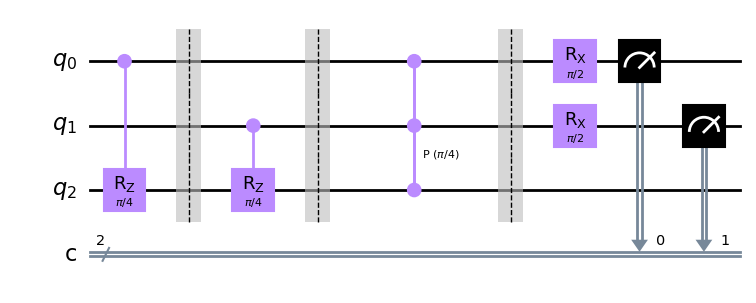

In [22]:
def mixer(qc, num_qubit, beta):
    # apply rx gate to each one
    for i in range(num_qubit):
        qc.rx(beta*2, i)
    qubit_range = list(range(num_qubit))
    qc.measure(qubit_range, qubit_range)
    return qc

# combine seperator and mixer
def max2sat(clause_all, gamma, beta):
    qc, count = sep(clause_all, gamma)
    return mixer(qc, count, beta)

beta = np.pi/4
qc = max2sat(clause_all, gamma, beta)
qc.draw(output='mpl')

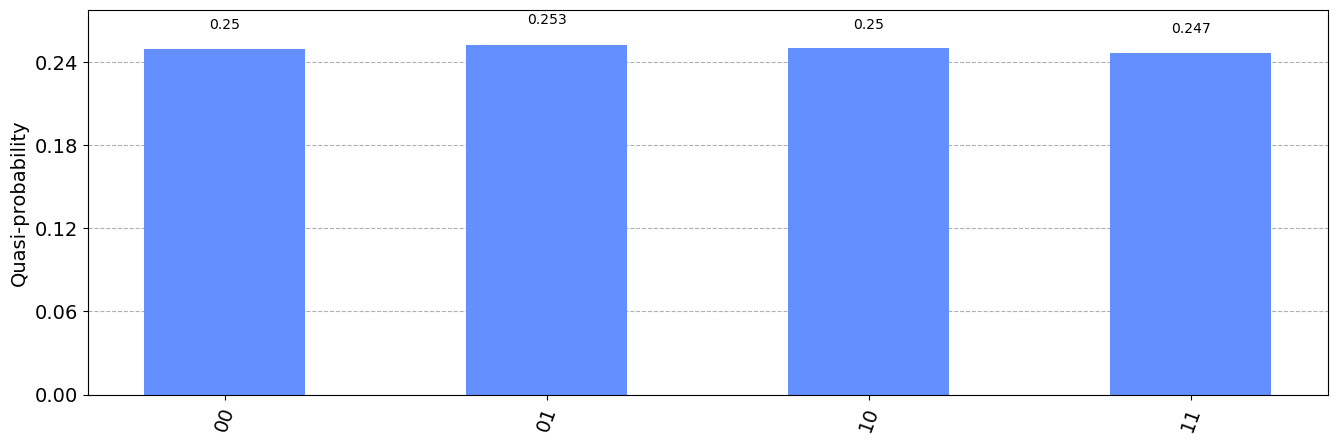

In [23]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 10000
count_qc = execute(qc, sim, shots=shots).result().get_counts()
keys = list(count_qc.keys())
# calcualte the normalized probability instead of total values
for key in count_qc:
    count_qc[key] = count_qc[key] / shots
plot_histogram(count_qc, figsize=(16,5))

In [24]:
# this function evaluates the output from simulator in the clauses
# to see how many clauses each output satisfy
# returns a dictionary
def evalute_clause(clause_all, keys):
    correct_arr = []
    for key in keys:
        correct_num = 0
        for clause in clause_all:
            if type(clause) == type(1):
                continue
            literal1 = int(key[clause[0]]) * (-1)**clause[2]
            literal2 = int(key[clause[1]]) * (-1)**clause[3]
            if literal1 or literal2:
                correct_num = correct_num + 1
        correct_arr.append(correct_num)
    return correct_arr

count = evalute_clause(clause_all, keys)
evalution_dic = dict(zip(keys, count))

# calcualte the expectation value for minimization
def expectation(count_qc, evalution_dic):
    new_dict = {}
    for key in evalution_dic:
        exp = evalution_dic[key] * count_qc[key]
        new_dict[key] = exp
    return new_dict

def sum_dict_values(input_dict):
    """
    Sum all the values in the given dictionary.

    Args:
    input_dict (dict): A dictionary with values that are numeric.

    Returns:
    int or float: The sum of all the values in the dictionary.
    """
    return sum(input_dict.values())

exp_arr = expectation(count_qc, evalution_dic)
value = sum_dict_values(exp_arr)
print(value)

0.75


In [25]:
from scipy.optimize import minimize

# create the total circuit, calcualte expectation of probability 
# return expectation of probability * -1
def everything(initial, args):
    gamma, beta = initial
    clause_all = args[0]
    qc, count = sep(clause_all, gamma)
    qc =  mixer(qc, count, beta)
    
    ## Run this cell to simulate 'qc4' and to plot the histogram of the result
    sim = Aer.get_backend('qasm_simulator')
    shots = 10000
    count_qc = execute(qc, sim, shots=shots).result().get_counts()
    keys = list(count_qc.keys())
    # calcualte the normalized probability instead of total values
    for key in count_qc:
        count_qc[key] = count_qc[key] / shots
    count = evalute_clause(clause_all, keys)
    evalution_dic = dict(zip(keys, count))
    exp_arr = expectation(count_qc, evalution_dic)
    value = sum_dict_values(exp_arr)
    return -value

# minimize the expectation to get optimal beta and gamma
result = minimize(everything, x0 = [(np.random.rand(1)*np.pi*2)[0], (np.random.rand(1)*np.pi*2)[0]], args=[clause_all], bounds=[(0, 2*np.pi) , (0, 2*np.pi)])
print(result)


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -0.9947
        x: [ 4.869e+00  1.308e+00]
      nit: 1
      jac: [ 2.100e+05  7.000e+04]
     nfev: 117
     njev: 39
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


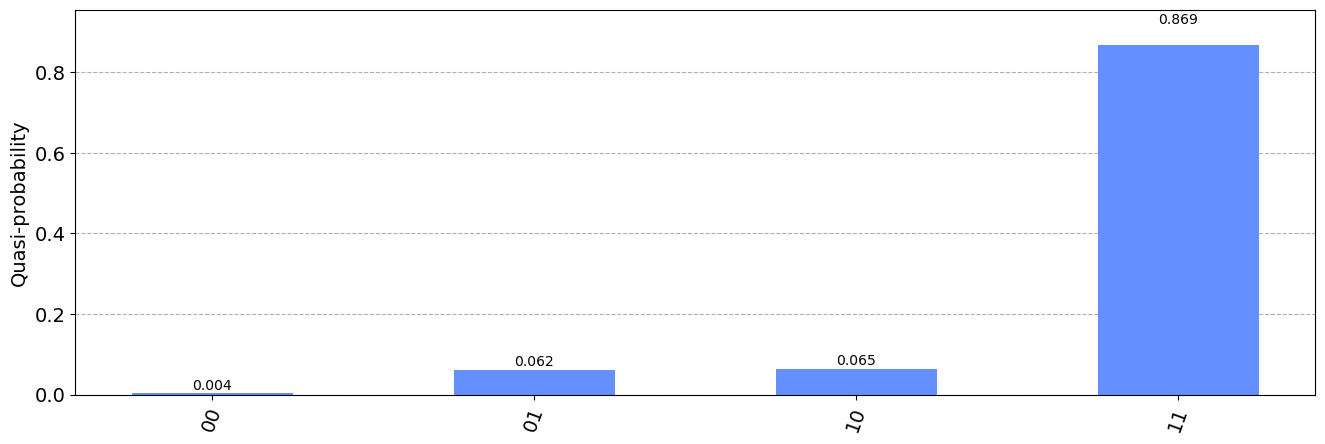

In [26]:
gamma, beta = result.x
qc, count = sep(clause_all, gamma)
qc =  mixer(qc, count, beta)

## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 10000
count_qc = execute(qc, sim, shots=shots).result().get_counts()
keys = list(count_qc.keys())
# calcualte the normalized probability instead of total values
for key in count_qc:
    count_qc[key] = count_qc[key] / shots
plot_histogram(count_qc, figsize=(16,5))

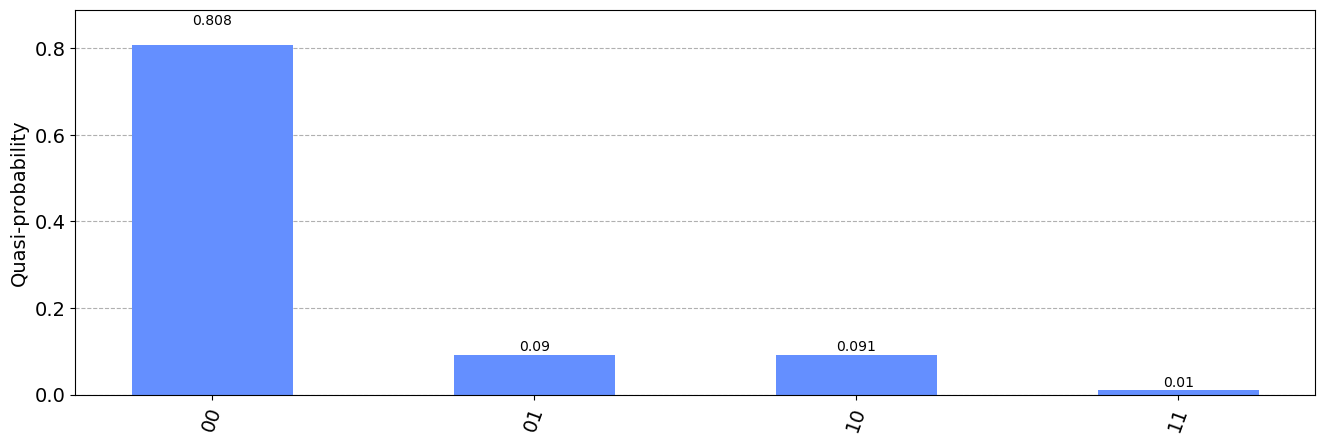

In [41]:
clause_all = [2, [0, 1, 0, 0]]
gamma, beta = result.x
qc, count = sep(clause_all, gamma)
qc =  mixer(qc, count, beta*1.2)

## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 10000
count_qc = execute(qc, sim, shots=shots).result().get_counts()
keys = list(count_qc.keys())
# calcualte the normalized probability instead of total values
for key in count_qc:
    count_qc[key] = count_qc[key] / shots
plot_histogram(count_qc, figsize=(16,5))

In [27]:
## Your code goes here.  
IBMQ.save_account('3b1689f2998f67f9eea3d8005808b0e68283c281cb89f0029f9aa80dc8bb1520def70af82e78c0642fd6ebfb4eaf6618e06c0b29000017412ec58e5778f0684a')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = provider.get_backend('ibm_osaka')

configrc.store_credentials:WARNING:2023-12-14 21:50:48,229: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-12-14 21:50:48,469: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


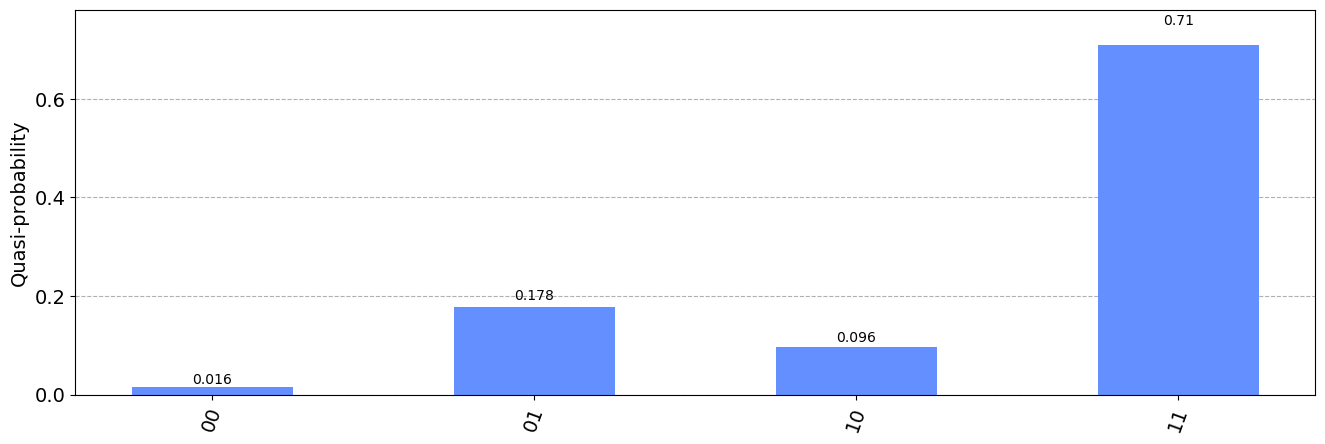

In [28]:
shots = 8000
qc_trans = transpile(qc, backend = backend, optimization_level=3)
job = backend.run(qc_trans, shots=shots)
job_monitor(job)
output = job.result().get_counts()
# calcualte the normalized probability instead of total values
for key in output:
    output[key] = output[key] / shots
plot_histogram(output, figsize=(16,5))

# Another Clause

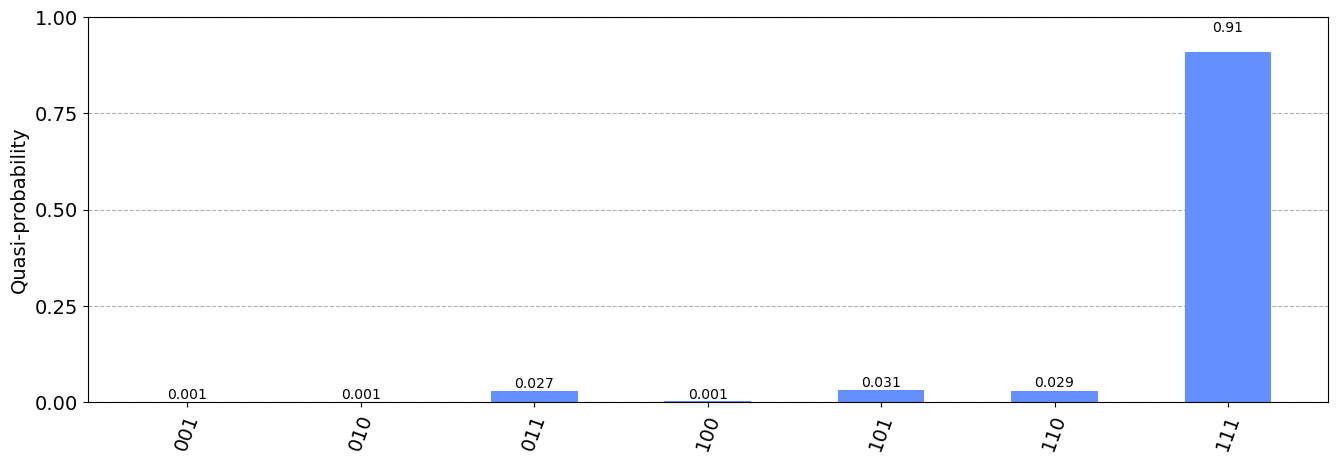

In [39]:
clause_all = [3, [0, 1, 0, 0], [1,2,1,0]]

def classical_optimization(clause_all):
    result = minimize(everything, x0 = [(np.random.rand(1)*np.pi*2)[0], (np.random.rand(1)*np.pi*2)[0]], args=[clause_all], bounds=[(0, 2*np.pi) , (0, 2*np.pi)])
    return result.x



gamma, beta = classical_optimization(clause_all)
qc, count = sep(clause_all, gamma)
qc =  mixer(qc, count, beta)

## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 10000
count_qc = execute(qc, sim, shots=shots).result().get_counts()
keys = list(count_qc.keys())
# calcualte the normalized probability instead of total values
for key in count_qc:
    count_qc[key] = count_qc[key] / shots
plot_histogram(count_qc, figsize=(16,5))

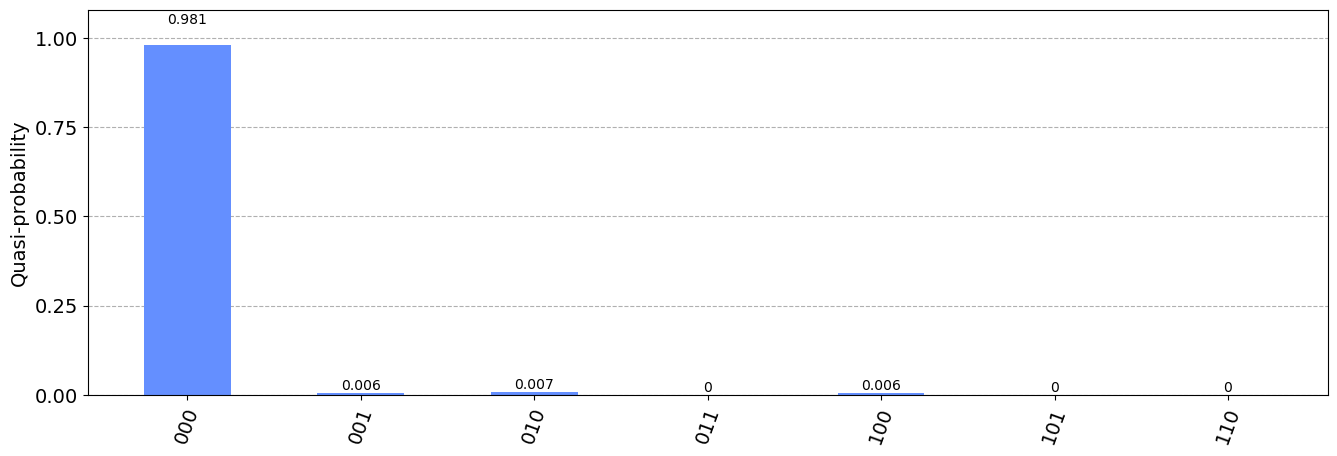

In [43]:
clause_all = [3, [0, 1, 0, 0], [1,2,1,0]]

def classical_optimization(clause_all):
    result = minimize(everything, x0 = [(np.random.rand(1)*np.pi*2)[0], (np.random.rand(1)*np.pi*2)[0]], args=[clause_all], bounds=[(0, 2*np.pi) , (0, 2*np.pi)])
    return result.x



gamma, beta = classical_optimization(clause_all)
qc, count = sep(clause_all, gamma)
qc =  mixer(qc, count, beta*1.5)

## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 10000
count_qc = execute(qc, sim, shots=shots).result().get_counts()
keys = list(count_qc.keys())
# calcualte the normalized probability instead of total values
for key in count_qc:
    count_qc[key] = count_qc[key] / shots
plot_histogram(count_qc, figsize=(16,5))

Job Status: job has successfully run


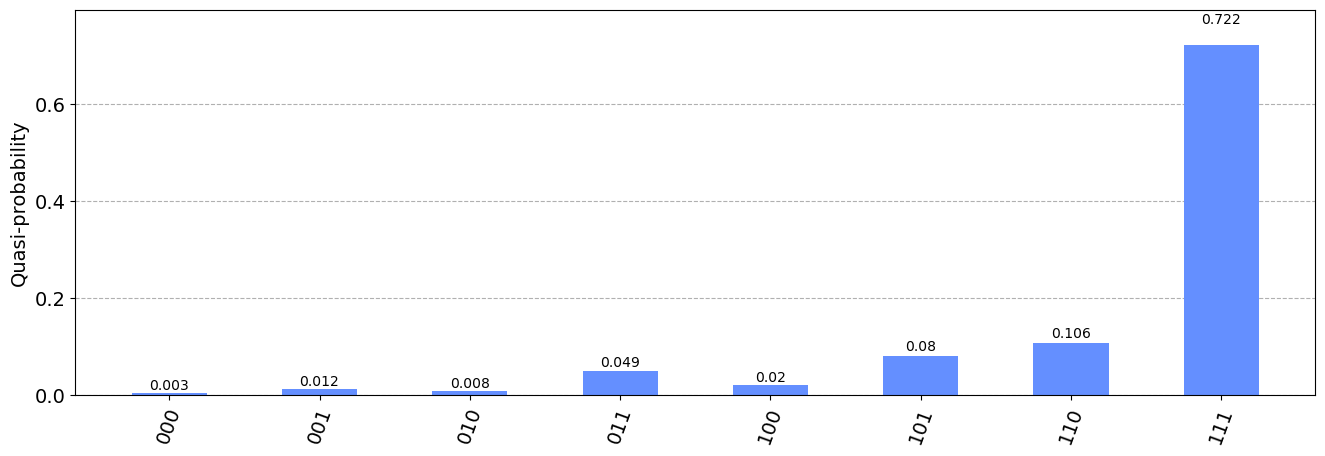

In [40]:
shots = 8000
qc_trans = transpile(qc, backend = backend, optimization_level=3)
job = backend.run(qc_trans, shots=shots)
job_monitor(job)
output = job.result().get_counts()
# calcualte the normalized probability instead of total values
for key in output:
    output[key] = output[key] / shots
plot_histogram(output, figsize=(16,5))

# Qubit numbers grow

In [31]:
import time
def create_clause(n):
    clause_all = [0]
    for i in range(n):
        new_clause = [i, i+1, 0, 0]
        clause_all.append(new_clause)
        clause_all[0] = clause_all[0]+1
    clause_all[0] = clause_all[0]+1
    return clause_all

## Simulator

In [37]:
time_arr = []
for i in range(4,26):
    start_time = time.time()
    clause_all = create_clause(i)
    
    qc = max2sat(clause_all,np.pi/2, np.pi/2)
    ## Run this cell to simulate 'qc4' and to plot the histogram of the result
    sim = Aer.get_backend('qasm_simulator')
    shots = 10000
    count_qc = execute(qc, sim, shots=shots).result().get_counts()
    keys = list(count_qc.keys())
    # calcualte the normalized probability instead of total values
    for key in count_qc:
        count_qc[key] = count_qc[key] / shots
    plot_histogram(count_qc, figsize=(16,5))

    end_time = time.time()
    time_arr.append(end_time - start_time)

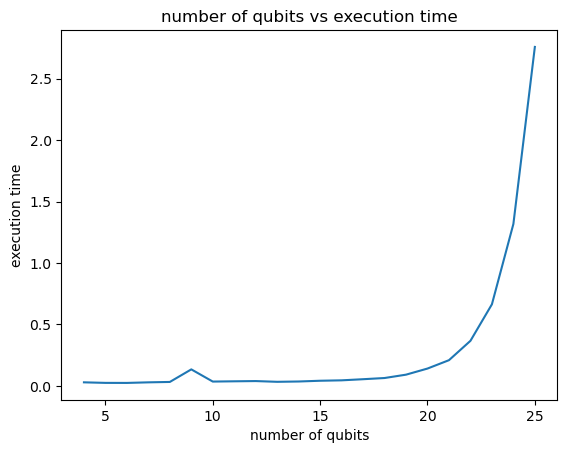

In [38]:
plt.plot(list(range(4,26)), time_arr)
plt.xlabel('number of qubits')
plt.ylabel('execution time')
plt.title('number of qubits vs execution time')
plt.savefig('QAOA_qubits_simulator.png')

## Osaka real computer

In [34]:
time_arr = []
for i in range(4,12):
    start_time = time.time()
    clause_all = create_clause(i)
    
    qc = max2sat(clause_all,np.pi/2, np.pi/2)
    shots = 8000
    qc_trans = transpile(qc, backend = backend, optimization_level=3)
    job = backend.run(qc_trans, shots=shots)
    job_monitor(job)
    output = job.result().get_counts()

    end_time = time.time()
    time_arr.append(end_time - start_time)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


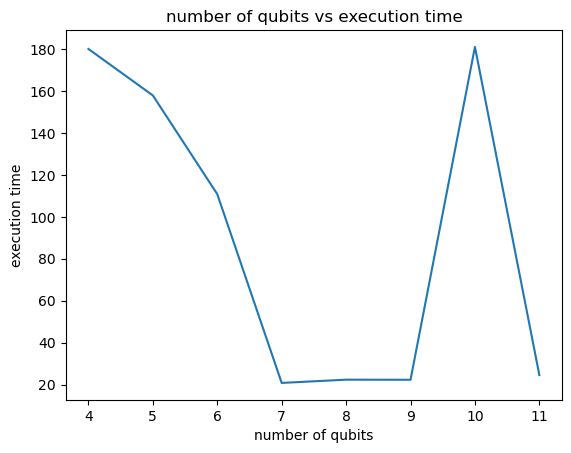

In [35]:
plt.plot(list(range(4,12)), time_arr)
plt.xlabel('number of qubits')
plt.ylabel('execution time')
plt.title('number of qubits vs execution time')
plt.show()

# reliability noisy simulator

In [49]:
from qiskit import Aer, QuantumCircuit, execute
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend)
result = []
for n in range(5,22):
    clause_all = create_clause(n)

    gamma, beta = classical_optimization(clause_all)
    qc, count = sep(clause_all, gamma)
    qc =  mixer(qc, count, beta*1.5)

    ## Run this cell to simulate 'qc4' and to plot the histogram of the result
    sim = Aer.get_backend('qasm_simulator')
    shots = 10000
    count_qc = execute(qc, sim, noise_model=noise_model).result().get_counts()
    keys = list(count_qc.keys())
    # calcualte the normalized probability instead of total values
    for key in count_qc:
        count_qc[key] = count_qc[key] / shots
    key_with_highest_value = max(count_qc, key=count_qc.get)
    result.append(key_with_highest_value)



In [50]:
print(result)

['111111', '1111111', '00000000', '000000000', '1111111111', '11111111111', '000000000000', '1001101110010', '11111111111111', '111111111111111', '1010000100000100', '00000000000000000', '111111111111111111', '1101111101111011111', '00000000101001000101', '000000000001000000001', '1111111111111111111111']
